# Predicción de diabetes 

In [17]:
import streamlit as st 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import io
import plotly.graph_objects as go
import joblib

sns.set_theme(style="whitegrid")

# Dataset Card


## Ficha Técnica del Dataset: Capital Bikeshare

Este conjunto de datos proviene originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. Su objetivo es predecir diagnósticamente si un paciente padece diabetes, basándose en ciertas mediciones diagnósticas incluidas en el conjunto de datos. Se aplicaron varias restricciones a la selección de estos casos de una base de datos más amplia. En particular, todos los pacientes aquí presentes son mujeres de al menos 21 años de ascendencia indígena pima.

### 0.1. Metadatos Principales
| Característica | Detalle |
| :--- | :--- |
| **Fuente Original** | Kaggle |
| **Tipo de Problema** | Clasificación binaria |
| **Instancias (Filas)** | 2,460 (pacientes) |
| **Variables (Columnas)** | 8 características + Target |
| **Tipo de Atributos** | Enteros, Reales |
| **Datos Faltantes** | No se observan valoren nulos o faltantes |


### 0.2. Diccionario de Datos (Variables)
Entender qué significa cada columna es crucial para el análisis:

* **Variables Características:**
- `Embarazos (Pregnancies):` número de veces que la paciente ha estado embarazada.  
- `Glucosa (Glucose):` concentración de glucosa plasmática medida a las 2 horas durante una prueba oral de tolerancia a la glucosa.  
- `Presión arterial (Blood Pressure):` presión arterial diastólica, medida en mm Hg.  
- `Espesor del pliegue cutáneo (Skin Thickness):` espesor del pliegue cutáneo del tríceps, medido en milímetros.  
- `Insulina (Insulin):` nivel de insulina sérica a las 2 horas, medido en µU/ml.  
- `Función de pedigrí de diabetes (Diabetes Pedigree Function):` índice que estima la probabilidad de diabetes en función del historial familiar.  
- `Edad (Age):` edad de la paciente, expresada en años.  

* **Variable Objetivo (Target):**
    * `Resultado (Outcome)`: variable objetivo o de clasificación (0 o 1), donde **1** indica un diagnóstico positivo de diabetes y **0** un diagnóstico negativo.

## EDA

In [18]:
#cargar el dataset
df = pd.read_csv("Training.csv")

#mostrar primeras filas
df.head(10)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [19]:
#mostrar información del dataset 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2460 non-null   int64  
 1   Glucose                   2460 non-null   int64  
 2   BloodPressure             2460 non-null   int64  
 3   SkinThickness             2460 non-null   int64  
 4   Insulin                   2460 non-null   int64  
 5   BMI                       2460 non-null   float64
 6   DiabetesPedigreeFunction  2460 non-null   float64
 7   Age                       2460 non-null   int64  
 8   Outcome                   2460 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 173.1 KB


In [20]:
#mostrar descripción del dataset

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,2460.0,3.817480,3.296458,0.000,1.00000,3.000,6.000,17.00
Glucose,2460.0,121.602033,31.789270,0.000,100.00000,117.000,142.000,197.00
BloodPressure,2460.0,68.915041,19.082655,0.000,64.00000,70.000,80.000,122.00
SkinThickness,2460.0,20.531301,15.716901,0.000,0.00000,23.000,33.000,63.00
Insulin,2460.0,80.119919,116.765807,0.000,0.00000,36.000,129.000,846.00
BMI,2460.0,31.990447,7.802569,0.000,27.10000,32.100,36.500,67.10
DiabetesPedigreeFunction,2460.0,0.491440,0.363917,0.078,0.25175,0.381,0.647,2.42
Age,2460.0,32.821951,11.251208,21.000,24.00000,29.000,39.000,81.00
Outcome,2460.0,0.390244,0.487904,0.000,0.00000,0.000,1.000,1.00


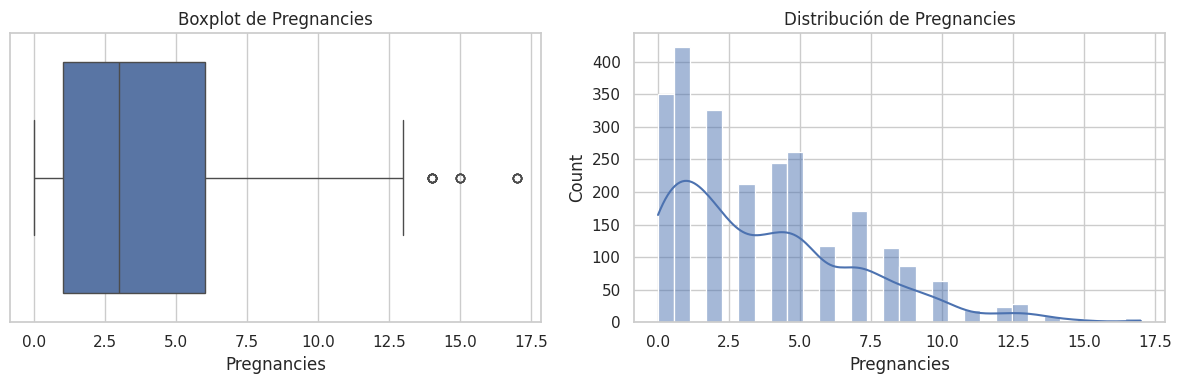

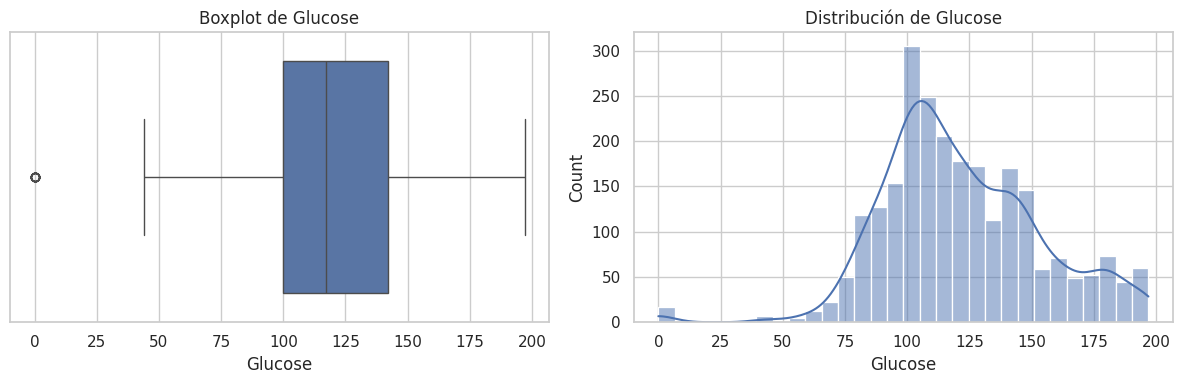

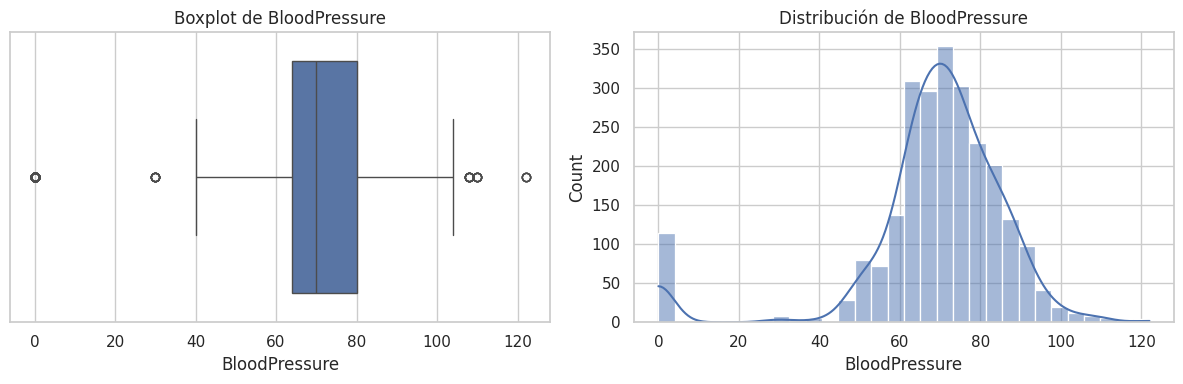

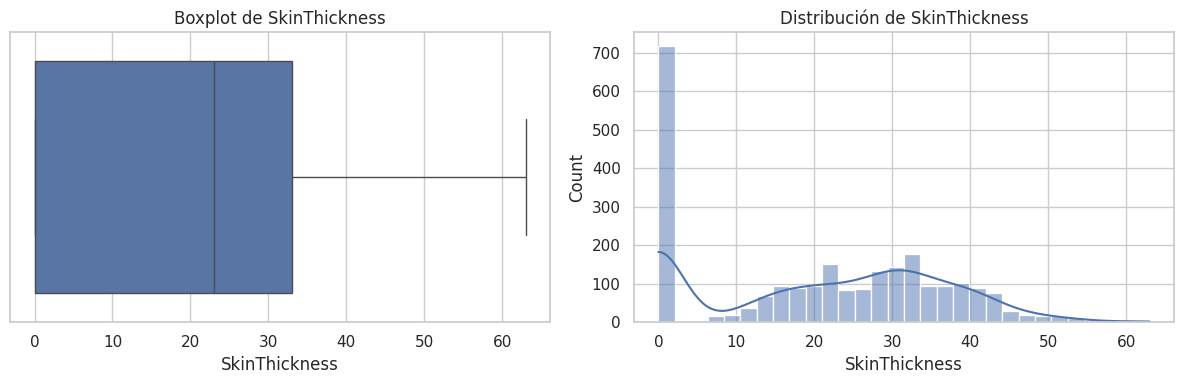

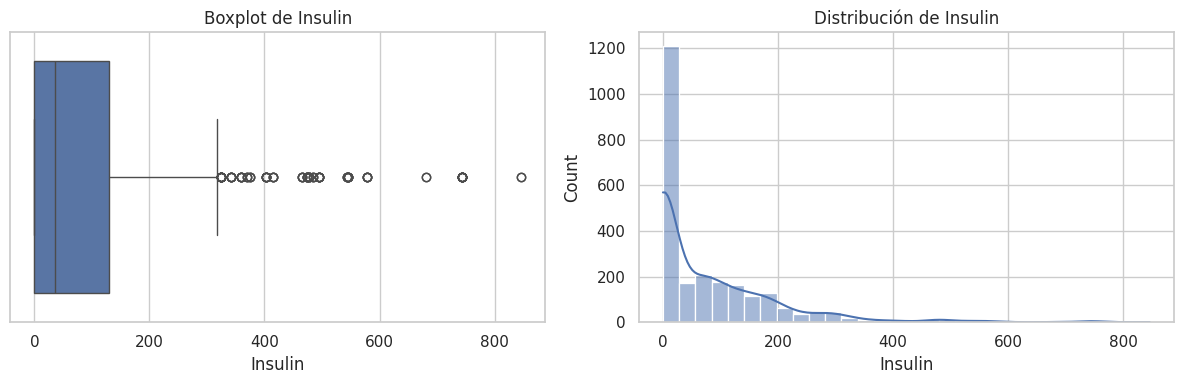

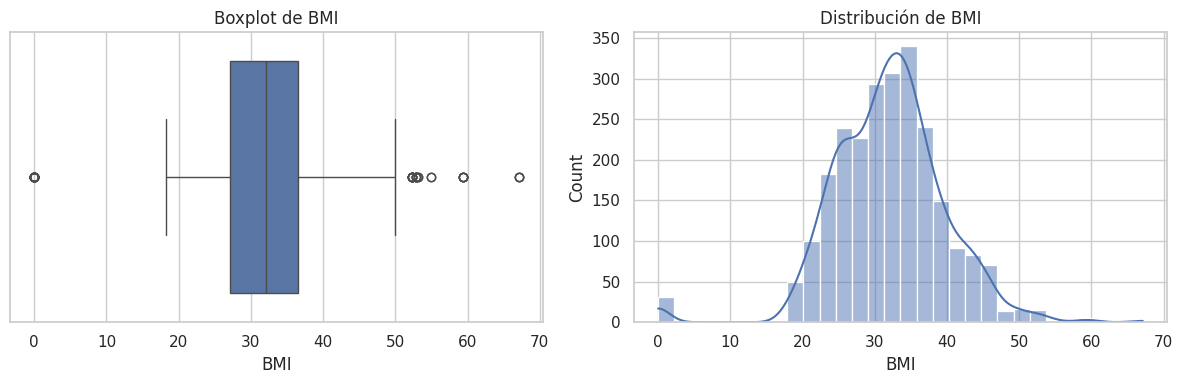

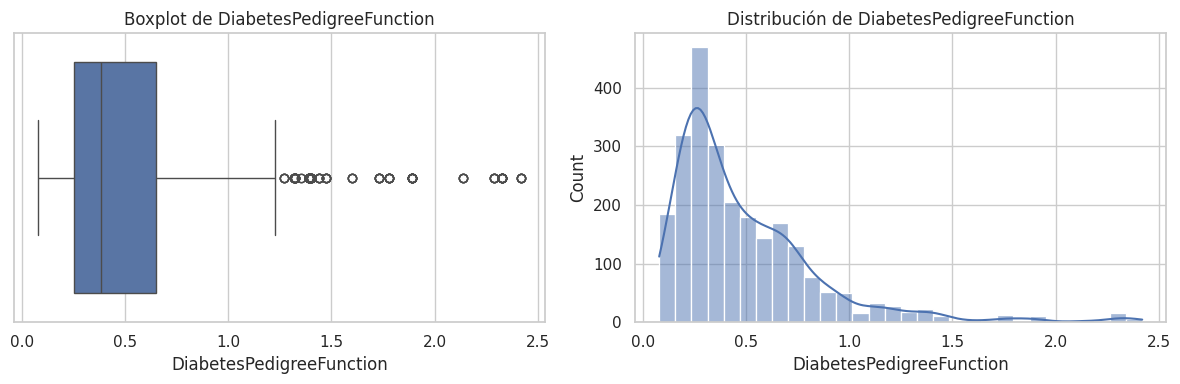

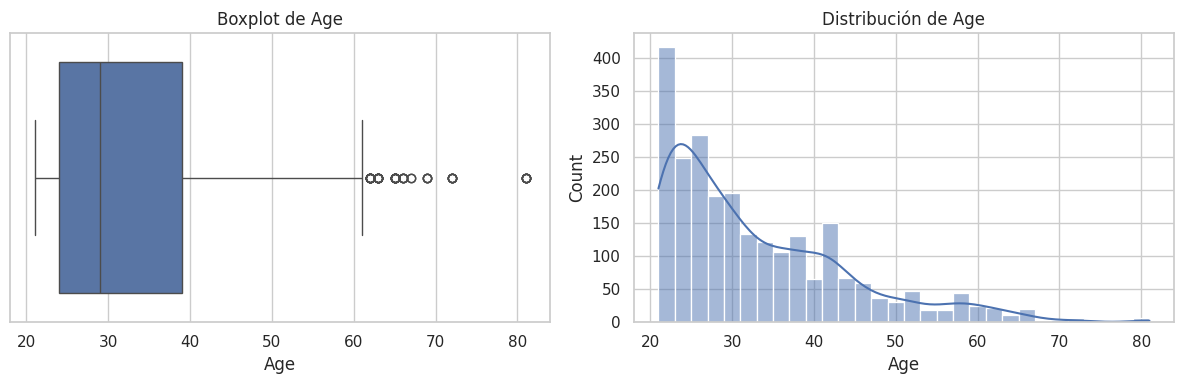

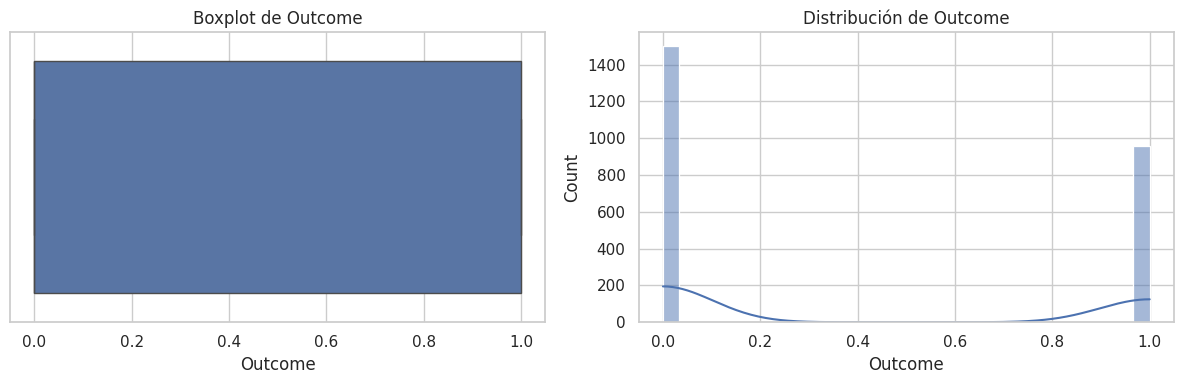

In [25]:
%matplotlib inline
#Seleccionar datos numéricos únicamente
numeric_cols = df.select_dtypes(include="number").columns
#omitir columnas constantes
numeric_cols = [c for c in numeric_cols if df[c].nunique() > 1]

#Boxplot para todas las columnas numéricas y distribución de variables
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.boxplot(x=df[col], ax=axes[0])
    axes[0].set_title(f"Boxplot de {col}")

    sns.histplot(df[col], kde=True, bins=30, ax=axes[1])
    axes[1].set_title(f"Distribución de {col}")

    plt.tight_layout()
    plt.show()



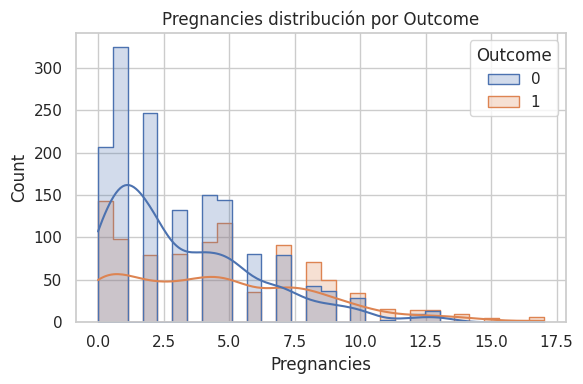

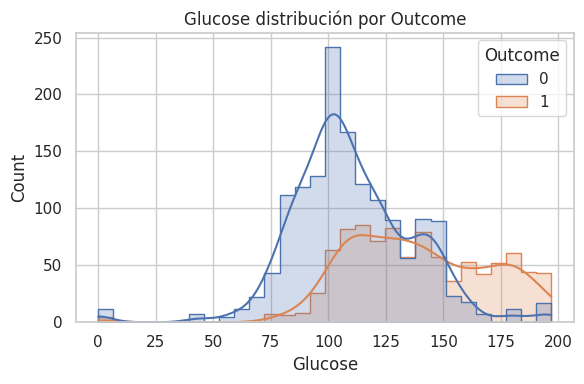

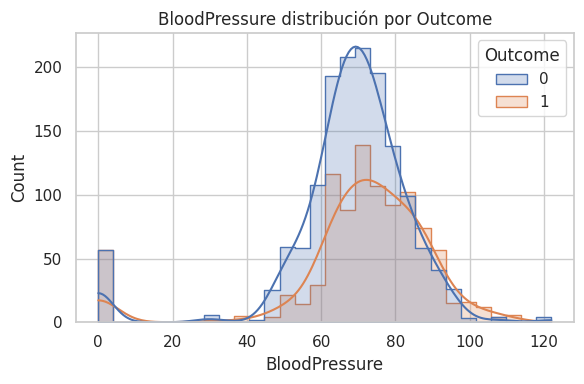

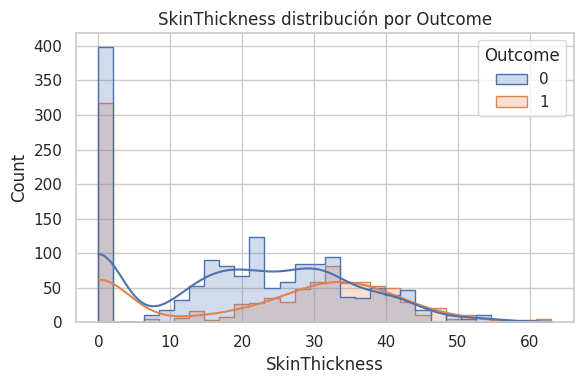

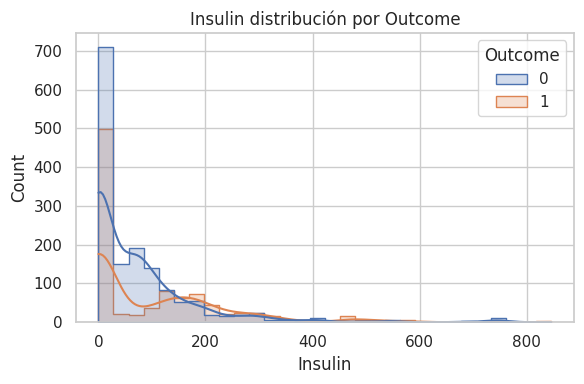

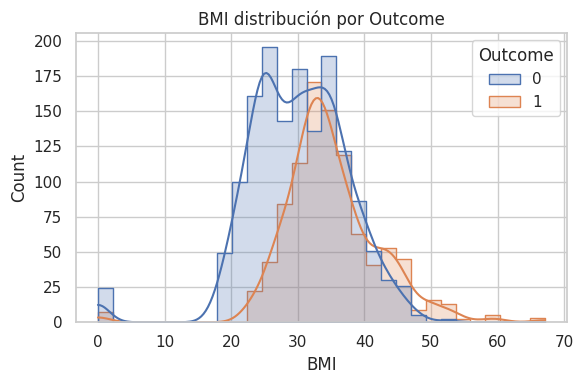

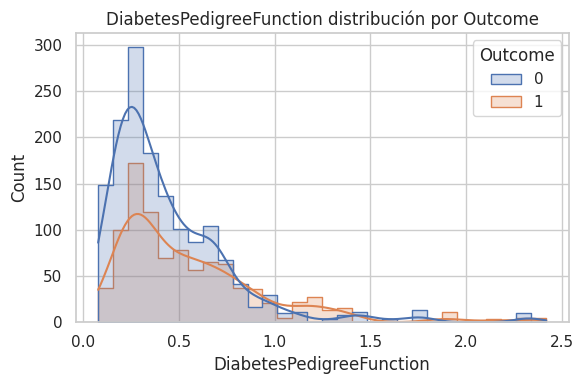

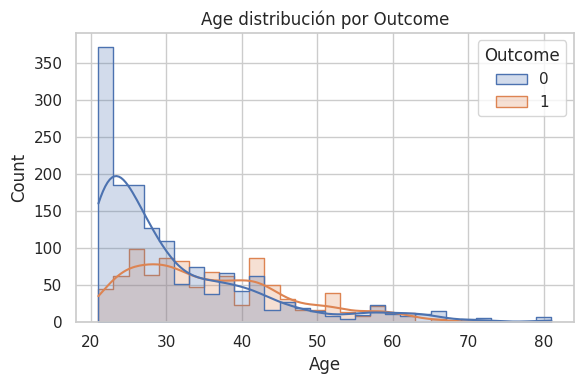

In [26]:
#Distribución por variable objetivo
target_col = "Outcome"

for col in numeric_cols:
    if col != target_col:
        plt.figure(figsize=(6, 4))
        sns.histplot(
            data=df,
            x=col,
            hue=target_col,
            kde=True,
            bins=30,
            element="step"
        )
        plt.title(f"{col} distribución por {target_col}")
        plt.tight_layout()
        plt.show()
